# Imports

In [1]:
import pysweep
import qcodes as qc
import pysweep.databackends.debug
import pysweep.databackends.list_backend
import pysweep.databackends.qcodes
import pysweep.core.measurementfunctions
from pysweep.core.sweepobject import SweepObject
from pysweep.core.measurementfunctions import MakeMeasurementFunction
from pysweep.databackends.base import DataParameterFixedAxis
import pysweep.convenience as conv
import random
import time
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

In [2]:
from pysweep.databackends.base import DataParameter
from pytopo.qctools.dataset2 import select_experiment
from qcodes.dataset.measurements import Measurement

from qcodes import load_by_id
import qcodes as qc
import qcodes.dataset.plotting
import importlib

C:\Anaconda3\envs\qcodes-env2\lib\site-packages\qcodes\dataset\sqlite_base.py:51: UserWarning: The module `qcodes.dataset.sqlite_base` is deprecated.
Public features are available at the import of `qcodes`.
Private features are available in `qcodes.dataset.sqlite.*` modules.
  warnings.warn('The module `qcodes.dataset.sqlite_base` is deprecated.\n'


In [3]:
station = qc.Station()
qc.initialise_or_create_database_at('testdata.db')

# Define a few parameters with physics

In [4]:
# Define dummy parameters representing DC bias and two gate voltages
bias = qc.instrument.parameter.ManualParameter("bias", units="V")
T1 = qc.instrument.parameter.ManualParameter("T1", units="V")
T2 = qc.instrument.parameter.ManualParameter("T2", units="V")

# Set the dummy parameters
bias(0)
T1(0)
T2(0)

# Helper function to generate a shape of a pinch off for fake measurement
def pinchoff(v, rs=10e3, l=2e-6, muc=3*60e-18, vth=-1):
    if v>vth:
        return (rs+l**2/(muc*(v-vth)))
    else:
        return 1e11

# Gettable parameter that represents a measured quantity
def get_current():
    u = bias()
    r = pinchoff(T1())+pinchoff(T2())
    return u/r
current = qc.instrument.parameter.Parameter("current", units="A", get_cmd=get_current)

# Other gettable parameter
def S21(f):
    s21 = 5e6**2/(5e6**2+(f-100e6)**2)
    c = 1/(pinchoff(T1())+pinchoff(T2()))
    s21 *= np.exp(-c/10e-6)
    return 1-s21


# Define the functions that define the measurement

We need to define what happens at the start of a measurement, what must happen at the end of a measurement and finally what a measurement entails

## Initialization and end functions

We need to define what happens at the start of a measurement and what must happen at the end of a measurement

In [5]:
# A function that will be called before the beginning of the measurement loop to prepare a setup
def init_measurement(d):
    bias(1e-3)

# A function that will be called after the end of the measurement loop to bring
# the setup back to neutral configuration
def end_measurement(d):
    bias(0)

## Measurement functions

Finally, we will need to define what a measurement entails. Any measurement that pysweep does is encapsulated as a MeasurementFucntion class. It contains a function that returns the measurement results as a list, as well as a list containing the metadata for every return value, this list is called the `ParamStruct`

In [6]:
# The parameter to be measured is wrapped to a format compatible with pysweep
@MakeMeasurementFunction([pysweep.DataParameter(name='current', unit='A')])
def measure(d):
    return [current()] # list of measurement outcomes

# A measurement function can also return multiple values
@MakeMeasurementFunction([pysweep.DataParameter(name='current', unit='A'), pysweep.DataParameter(name='conductance', unit='S')])
def measure_two_parameters(d):
    c = current()
    b = bias()
    return [c, c/b] # list of measurement outcomes

lets also define a function the measures the hypothetical temperature of our fridge
Because the explicit definition of the DataParameter is overly verbose, we introduce the shorthand:

If an element `param` of the datastruct is not of type `DataParameter`, it will try to construct a dataparameters automatically as
`DataParameter(*param)`
as such we can define a measurementfunction as

In [7]:
@MakeMeasurementFunction([['Temperature', 'mK']])
def measure_temperature(d):
    return [random.randint(100, 300)/10]

# Simple measurements

Since we now have the functions that will be execute to measure something, we can now look at the code that will perform the sweeping

In pysweep, sweeps are performed with `SweepObjects` which consist of 4 elements
* set_function
* unit
* label
* point_function

For now, let us ignore the details and see how they can be constructed:

`pysweep.sweep_object(T1, np.linspace(0,-1.2,51))`

This encodes the idea of sweeping the `T1` gate from 0 to -1.2 in 51 steps (`np.linspace(0,-1.2,51)`)

With this extra component, we have enouigh to start performing measurements. This paragraph contains some measurements that corresponds to the easiest cases of measurements. The cases cover 90% of all measurements that will run, but don't show the full power of pysweep

## Basic 1D sweep

In [8]:
# check for existing experiment in the selected database, and create one if needed
exp = select_experiment('pinchoff', 'test_sample')
# create a QCoDeS measurement object
meas = Measurement(exp, station)

# the measurement loop
r = pysweep.sweep(init_measurement, # function executed before the beginning of the loop
              end_measurement,      # function executed after the end of the loop
              measure,              # measurement to be executed at each iteration
              pysweep.sweep_object(T1, np.linspace(0,-1.2,51)),  # specifies the parameter to loop over and a range
              databackend = pysweep.databackends.qcodes.DataBackend(meas) # selects the databackend to send the data to
            )

None3 , postponing registration
None2 , postponing registration
Starting experimental run with id: 67


([<matplotlib.axes._subplots.AxesSubplot at 0x2cbacd84d08>], [None])

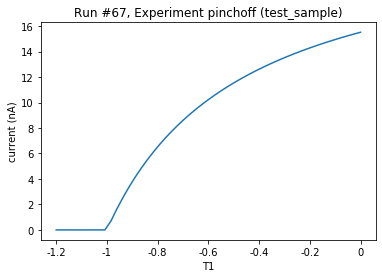

In [9]:
# plot the measured data
qcodes.dataset.plotting.plot_dataset(r.datasaver.dataset)

In [10]:
r.datasaver.dataset.snapshot['station']['components']['PysweepMetadata']['datashapes']

{'current': [51]}

## Basic 2D sweep

Adding another dimension is trivial, where we follow the rule that the inner most loop is at the top, closest to the `MeasurementFunction`

In [11]:
# get the measurement object
exp = select_experiment('pinchoff', 'test_sample')
meas = Measurement(exp, station)

# run the 2D sweep
r = pysweep.sweep(init_measurement,
                  end_measurement,
                  measure, 
              pysweep.sweep_object(T1, np.linspace(0,-1.2,51)), 
              pysweep.sweep_object(T2, np.linspace(0,-1.2,51)), 
              databackend = pysweep.databackends.qcodes.DataBackend(meas)
            )

None3 , postponing registration
Starting experimental run with id: 68


([<matplotlib.axes._subplots.AxesSubplot at 0x2cbacd6df88>],
 [<matplotlib.colorbar.Colorbar at 0x2cbad1fcd08>])

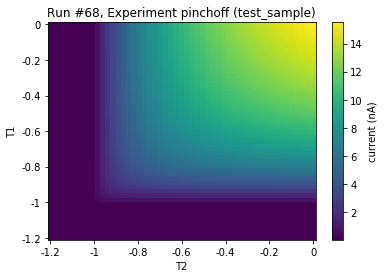

In [12]:
# plot the measured quantities
qcodes.dataset.plotting.plot_dataset(r.datasaver.dataset)

In [13]:
r.datasaver.dataset.snapshot['station']['components']['PysweepMetadata']['datashapes']

{'current': [51, 51]}

## Measure multiple parameters

As meantioned before, some `MeasurementFunctions` contain more than one parameter, which leads to the following measurement

In [14]:
# get the measurement object
exp = select_experiment('pinchoff', 'test_sample')
meas = Measurement(exp, station)
T1(0)
T2(0)

r = pysweep.sweep(init_measurement,
                  end_measurement,
                  measure_two_parameters, 
              pysweep.sweep_object(bias, np.linspace(-1e-3,1e-3,251)), 
              databackend = pysweep.databackends.qcodes.DataBackend(meas)
            )

None3 , postponing registration
None2 , postponing registration
Starting experimental run with id: 69


C:\Anaconda3\envs\qcodes-env2\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in double_scalars
  # This is added back by InteractiveShellApp.init_path()


([<matplotlib.axes._subplots.AxesSubplot at 0x2cbad0d0f88>,
 [None, None])

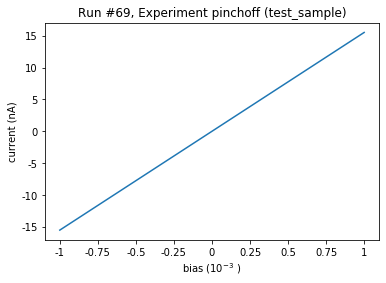

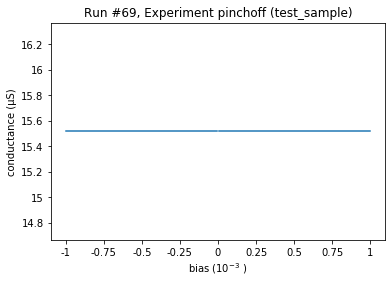

In [15]:
# plot the two measured quantities
qcodes.dataset.plotting.plot_dataset(r.datasaver.dataset)

In [16]:
r.datasaver.dataset.snapshot['station']['components']['PysweepMetadata']['datashapes']

{'current': [251], 'conductance': [251]}

# Extended examples

Here are a few examples of measurements that are still relatively simples, but with a few more bells and whistles

Say that we want to measure the fridge temperature in addition to the current. This can be done by creating the combined measurement object `measure+measure_temperature` and hence we simply execute

## Addition of measurement functions

In [17]:
exp = select_experiment('pinchoff', 'test_sample')
meas = Measurement(exp, station)

r = pysweep.sweep(init_measurement,
                  end_measurement,
                  measure+measure_temperature, # measurement functions support addition
              pysweep.sweep_object(T1, np.linspace(0,-1.2,51)), 
              pysweep.sweep_object(T2, np.linspace(0,-1.2,51)), 
              databackend=pysweep.databackends.qcodes.DataBackend(meas)
            )

None3 , postponing registration
Starting experimental run with id: 70


([<matplotlib.axes._subplots.AxesSubplot at 0x2cbae2fa6c8>,
  <matplotlib.colorbar.Colorbar at 0x2cbae2def08>])

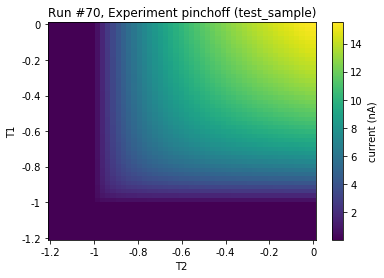

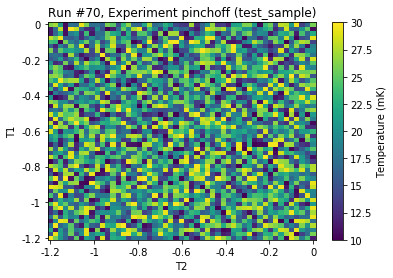

In [18]:
qcodes.dataset.plotting.plot_dataset(r.datasaver.dataset)

In [19]:
r.datasaver.dataset.snapshot['station']['components']['PysweepMetadata']['datashapes']

{'current': [51, 51], 'Temperature': [51, 51]}

## Measurements in the outer measurement loop

But often we only want to measure temperature every now and then, so let's assume that we want to measure the fridge tmeperature only after every time we set the T2 parameter

In [20]:
exp = select_experiment('pinchoff', 'test_sample')
meas = Measurement(exp, station)
r = pysweep.sweep(init_measurement,
                  end_measurement,
                  measure, 
              pysweep.sweep_object(T1, np.linspace(0,-1.2,51)), 
              conv.add_function(pysweep.sweep_object(T2, np.linspace(0,-1.2,51)), measure_temperature), 
              databackend = pysweep.databackends.qcodes.DataBackend(meas)
            )

None3 , postponing registration
Starting experimental run with id: 71


([<matplotlib.axes._subplots.AxesSubplot at 0x2cbae2cc5c8>,
 [None, <matplotlib.colorbar.Colorbar at 0x2cbae3e5188>])

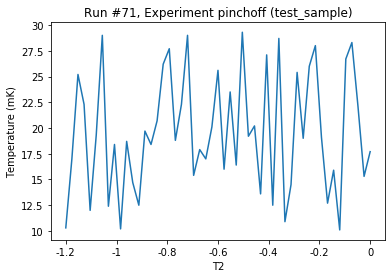

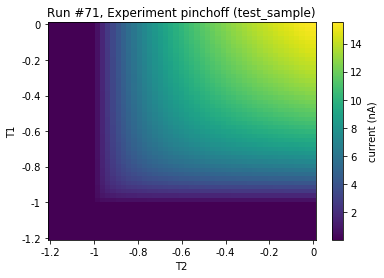

In [21]:
qcodes.dataset.plotting.plot_dataset(r.datasaver.dataset)

In [22]:
r.datasaver.dataset.snapshot['station']['components']['PysweepMetadata']['datashapes']

{'Temperature': [51], 'current': [51, 51]}

# Hardware sweep

## Measurement functions returning an array of coordinates and array of data

Several instruments internally perform a 1D (or multi-D) sweep and return an array values. For example VNA will return an array representing full dependence S21(f), which we may want to repeat as a function of some other parameter.

In [23]:
@MakeMeasurementFunction([['frequency', 'Herz', 'array', True], ['S11', 'dB', 'array']])
def transmission_vs_frequency_measurement_function(d):
    frequency_sweep_range = np.linspace(80e6, 120e6, 201)
    measured_S21 = S21(frequency_sweep_range)
    return [frequency_sweep_range, measured_S21]

Where we make explicit in the parameter definition that frequency and S11 are parameters of type array and that frequency is an independent parameter

When running the measurement, ensure to reopen T2 to measure the pinchoff along T1

In [24]:
exp = select_experiment('rf_pinchoff', 'test_sample')
meas = Measurement(exp, station)
T2(0)
r = pysweep.sweep(init_measurement, end_measurement, 
                  transmission_vs_frequency_measurement_function, 
              pysweep.sweep_object(T1, np.linspace(0,-1.2,51)), 
              databackend = pysweep.databackends.qcodes.DataBackend(meas)
            )

None3 , postponing registration
None2 , postponing registration
Starting experimental run with id: 72


([<matplotlib.axes._subplots.AxesSubplot at 0x2cbae4e0548>],
 [<matplotlib.colorbar.Colorbar at 0x2cbae5963c8>])

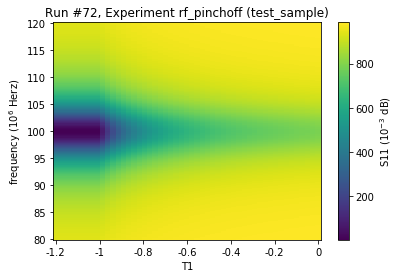

In [25]:
qcodes.dataset.plotting.plot_dataset(r.datasaver.dataset)

## Frequency range as an argument

It is often easier to define a function that constructs and returns a `MeasurementFunction` based on some input arguments. In the next example, we use the frequency range as an input argument to construct the correct `MeasurementFunction`

In [ ]:
# A function that creates a measurement function
def transmission_vs_frequency(frequency_sweep_range, suffix=''):
    
    # It is possible to tell pysweep in advance what frequency range we are sweeping over, 
    # which can assist life plotting
    # For pysweep, it does not matter wether we define the frequency range at the start 
    # of the measurement enabling adaptive sweeps, see the previous example
    # create a pysweep data parameter reperesenting a frequency
    # it is neccesary to ensure that it is treated as an independent variable
    frequency_parameter = DataParameterFixedAxis('Frequency'+suffix,
                                        'Hz',
                                        'array',
                                        frequency_sweep_range)
    
    #                        data parameter
    #                        for independent
    #                        variable               name    unit       type
    @MakeMeasurementFunction([frequency_parameter, ['S21'+suffix, 'arb. u.', 'array']])
    def transmission_vs_frequency_measurement_function(d):
        measured_S21 = S21(frequency_sweep_range)
        return [frequency_sweep_range, measured_S21]
    
    # return a measurement function
    return transmission_vs_frequency_measurement_function

In [ ]:
exp = select_experiment('pinchoff', 'test_sample')
meas = Measurement(exp, station)

T1(0)
T2(0)

# let's measure current and transmission
r = pysweep.sweep(init_measurement,
                  end_measurement,
                  measure+transmission_vs_frequency(np.linspace(80e6,120e6)), # a measurement function that returns anarray must be last to be added
                  pysweep.sweep_object(T1, np.linspace(0,-1.2,51)), 
                  databackend=pysweep.databackends.qcodes.DataBackend(meas)
            )

In [ ]:
qcodes.dataset.plotting.plot_dataset(r.datasaver.dataset)

# A note on parameter dependencies

To figure out which parameters depend on which parameters, pysweep uses a simple rule: every parameter depends on ALL independent parameters that occur earlier in the `paramstruct`

looking at the paramstruct of the previous measurement:

In [ ]:
r.columns

This assumption is usually correct but can lead to problems, for example in the next measurement which does not work
Because of the preceding rule, pysweep expects in the following piece of code that `current` will depend on `frequency`, which is of course not the case.

In [ ]:
exp = select_experiment('rf_pinchoff', 'test_sample')
meas = Measurement(exp, station)
T2(0)
try:
    r = pysweep.sweep(init_measurement, end_measurement, transmission_vs_frequency(np.linspace(80e6,120e6))+measure, 
                  pysweep.sweep_object(T1, np.linspace(0,-1.2,51)), 
                  databackend = pysweep.databackends.qcodes.DataBackend(meas)
                )
except ValueError as e:
    print(e)

### Simple solution

Switching around the two measurement functions solves this issue:

In [ ]:
exp = select_experiment('rf_pinchoff', 'test_sample')
meas = Measurement(exp, station)
T2(0)
r = pysweep.sweep(init_measurement, end_measurement, measure+transmission_vs_frequency(np.linspace(80e6,120e6)), 
                  pysweep.sweep_object(T1, np.linspace(0,-1.2,51)), 
                  databackend = pysweep.databackends.qcodes.DataBackend(meas)
                )

In [ ]:
qcodes.dataset.plotting.plot_dataset(r.datasaver.dataset)

### Advanced solution

In some cases it might be the case that both orders will not work. The usecase might be two incompatible hardware sweeps bundeled together.


Pysweep (with the qcodes backend) only allows one parameter with the same name per measurement, to avoid overwriting data. So the following code will return an error

In [ ]:
exp = select_experiment('rf_pinchoff', 'test_sample')
meas = Measurement(exp, station)
T2(0)
try:
    r = pysweep.sweep(init_measurement, end_measurement, 
                  transmission_vs_frequency(np.linspace(80e6,120e6, 11))+
                      transmission_vs_frequency(np.linspace(80e6,120e6, 101)), 
                  pysweep.sweep_object(T1, np.linspace(0,-1.2,51)), 
                  databackend = pysweep.databackends.qcodes.DataBackend(meas)
                )
except ValueError as e:
    print(e)

By using the `suffix` kwarg we can change the names on the fly, the following measurement will however still not work since the datashapes seem incompatible since pysweep incorrectly inferes the dependencies

In [ ]:
exp = select_experiment('rf_pinchoff', 'test_sample')
meas = Measurement(exp, station)
T2(0)
try:
    r = pysweep.sweep(init_measurement, end_measurement, 
                  transmission_vs_frequency(np.linspace(80e6,120e6, 11), suffix='_1')+
                      transmission_vs_frequency(np.linspace(80e6,120e6, 101), suffix='_2'), 
                  pysweep.sweep_object(T1, np.linspace(0,-1.2,51)), 
                  databackend = pysweep.databackends.qcodes.DataBackend(meas)
                )
except ValueError as e:
    print(e)

In this case the issue can also be resolved by explicitely telling pysweep that frequency and S11 are together and do not interfere with any other parameter.
Because the implicit syntax for the dataparameters gets confusing, I'll use the explicit notation here

In [ ]:
# A function that creates a measurement function
def transmission_vs_frequency_explicit(frequency_sweep_range, suffix=''):
    
    @MakeMeasurementFunction([pysweep.DataParameter(name='frequency'+suffix,
                                               unit='Hz',
                                               paramtype='array',
                                               # yes independent, but pysweep will not recognize it as such
                                               independent=2  
                                            ),
                         pysweep.DataParameter(name='S21'+suffix, 
                                              unit='dB',
                                              paramtype='array',
                                               # explicitely tell that this parameter depends on 
                                               # the corresponding frequency parameter
                                              extra_dependencies=['frequency'+suffix]  
                                              )])
    def transmission_vs_frequency_measurement_function(d):
        measured_S21 = S21(frequency_sweep_range)
        return [frequency_sweep_range, measured_S21]
    
    # return a measurement function
    return transmission_vs_frequency_measurement_function

In [ ]:
exp = select_experiment('rf_pinchoff', 'test_sample')
meas = Measurement(exp, station)
T2(0)
r = pysweep.sweep(init_measurement, end_measurement, 
                  transmission_vs_frequency_explicit(np.linspace(80e6,120e6, 11), suffix='_1')+
                  transmission_vs_frequency_explicit(np.linspace(80e6,120e6, 101), suffix='_2'), 
                  pysweep.sweep_object(T1, np.linspace(0,-1.2,51)), 
                  databackend = pysweep.databackends.qcodes.DataBackend(meas)
                )

In [ ]:
qcodes.dataset.plotting.plot_dataset(r.datasaver.dataset)

# Adaptive sweep - under construction

In [ ]:
@MakeMeasurementFunction([['timestamp', 's']])
def smart_point_function(dict_waterfall):
    timestamp = int(time.time())
    points = [int(c) for c in str(timestamp)]
    return points, [timestamp]

In [ ]:
db = pysweep.databackends.debug.DebugDataBackend()
pysweep.sweep(lambda d:{}, lambda d:{}, measure, 
              pysweep.sweep_object(a, [0,1]),
              conv.add_function(pysweep.sweep_object(b, [3,4]), measure_temperature),
              pysweep.sweep_object(c, smart_point_function, dataparameter=np.linspace(0,9,10)), databackend=db
             )

# Real life example - under construction

In [ ]:
%%enqueue single_shot_readout
exp = select_experiment('blobs', SAMPLE)
meas = Measurement(exp, station)
singleshot_dataextractor.setup_acquisition(1024, 1000, 100)
#4.77946e9
parameter_list = [[station.TI.NW_bias, 0e-3], [station.HT.frequency, 4779770000], [station.HT.RF.power, -20.25]]

pysweep.sweep(sf.set_parameters_after(init_rf, parameter_list), end_rf, 
              measure_singleshot_rf,
              pysweep.sweep_object(station.TI.SP4, 
                                   snr_calibrate_plunger(pysweep.sweep_object(station.TI.SP4, np.linspace(0., 0.4, 101))), dataparameter=[0,1]),
              pysweep.convenience.add_function(pysweep.sweep_object(station.TI.T5, np.linspace(-1, -1.35, 101)), csc),
              databackend = pysweep.databackends.qcodes.DataBackend(meas)
             )
rigol.ch1_output_enabled(False)

# Jagged Data Structures - under construction

In [ ]:
?DataParameter

In [ ]:
@MakeMeasurementFunction([DataParameter('time', 's', 'array', 2),
                         DataParameter('first_gate', 'V', 'array', 2),
                         DataParameter('second_gate', 'V', 'array', 2),
                         DataParameter('first_gate_result', 'I', 'array', extra_dependencies=['time', 'first_gate']),
                         DataParameter('time', 's', 'array', 2, duplicate=True),
                         DataParameter('second_gate_result', 'I', 'array', extra_dependencies=['time', 'second_gate'])])
def some_arbitrary_data(d):
    return [np.linspace(0,1, 11), np.linspace(0,0.1, 11), np.linspace(0,-0.1, 21), np.linspace(0,0.2, 11), np.linspace(1,2, 21), np.linspace(0,-0.2, 21)]

In [ ]:
importlib.reload(pysweep.databackends.qcodes)

In [ ]:
exp = select_experiment('jagged_data', 'test')
meas = Measurement(exp, station)

pysweep.sweep(init_measurement, end_measurement, 
              some_arbitrary_data,
              pysweep.sweep_object(T1, np.linspace(0,1,2)),
              databackend = pysweep.databackends.qcodes.CutDataBackend(meas)
             )

In [ ]:
raw_data = load_by_id(12)
data = raw_data.get_parameter_data()

In [ ]:
raw_data

In [ ]:
data['first_gate_result']['first_gate_result']

In [ ]:
plt.plot(data['first_gate_result']['first_gate'][0], data['first_gate_result']['first_gate_result'][0], '.')
plt.show()
plt.plot(data['second_gate_result']['second_gate'][0], data['second_gate_result']['second_gate_result'][0], '.')
plt.show()
plt.plot(data['first_gate_result']['time'][0], data['first_gate_result']['first_gate_result'][0], '.')
plt.plot(data['second_gate_result']['time'][0], data['second_gate_result']['second_gate_result'][0], '.')
plt.xlabel('time')
plt.ylabel('gate_result')
plt.show()

In [ ]:
from plottr.data.datadict import datadict_to_meshgrid
from plottr.data.qcodes_dataset import ds_to_datadict

In [ ]:
def load(runid):
    return datadict_to_meshgrid(ds_to_datadict(load_by_id(runid)))

In [ ]:
ds = ds_to_datadict(load_by_id(12))

In [ ]:
from plottr.node.data_selector import DataSelector

In [ ]:
dataselector = DataSelector('dataselector')

In [ ]:
ds

In [ ]:
ds2 = ds.extract(['first_gate_result'])

In [ ]:
ds3 = datadict_to_meshgrid(ds2)
ds3.validate()

In [ ]:
ds3.shape()

In [ ]:
ds3.structure(), ds3.shapes()

In [ ]:
ds3.sanitize()